In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os

In [ ]:
_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
# загружаем готовый набор изображений кошек и собак с данного адреса
path_to_zip = tf.keras.utils.get_file( "cats_and_dogs.zip",
origin=_URL,
extract=True)


68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
!find / -type d -name 'train'

/root/.keras/datasets/cats_and_dogs_extracted/cats_and_dogs_filtered/train
/usr/local/lib/python3.11/dist-packages/tensorflow/_api/v2/compat/v1/train
/usr/local/lib/python3.11/dist-packages/tensorflow/_api/v2/compat/v2/train
/usr/local/lib/python3.11/dist-packages/tensorflow/_api/v2/compat/v2/__internal__/train
/usr/local/lib/python3.11/dist-packages/tensorflow/_api/v2/train
/usr/local/lib/python3.11/dist-packages/tensorflow/_api/v2/__internal__/train
^C


In [ ]:
# при загрузке функция вернет полный путь до корня распакованного архива
PATH = os.path.join(os.path.dirname(path_to_zip),
"cats_and_dogs_extracted/cats_and_dogs_filtered")
# директория train будет источником данных для обучения модели
train_dir = os.path.join(PATH, "train")
# директория validation будет источником данных для вылидации
validation_dir = os.path.join(PATH, "validation")
BATCH_SIZE = 32 # можете установить по желанию любой другой размер пакета
IMG_SIZE = (150, 150) # приведем к этому размеру все картинки
# сохраняем датасет для обучения модели
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
shuffle=True,
batch_size=BATCH_SIZE,
image_size=IMG_SIZE)
# аналогично получаем датасет для валидации
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
shuffle=True,
batch_size=BATCH_SIZE,
image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


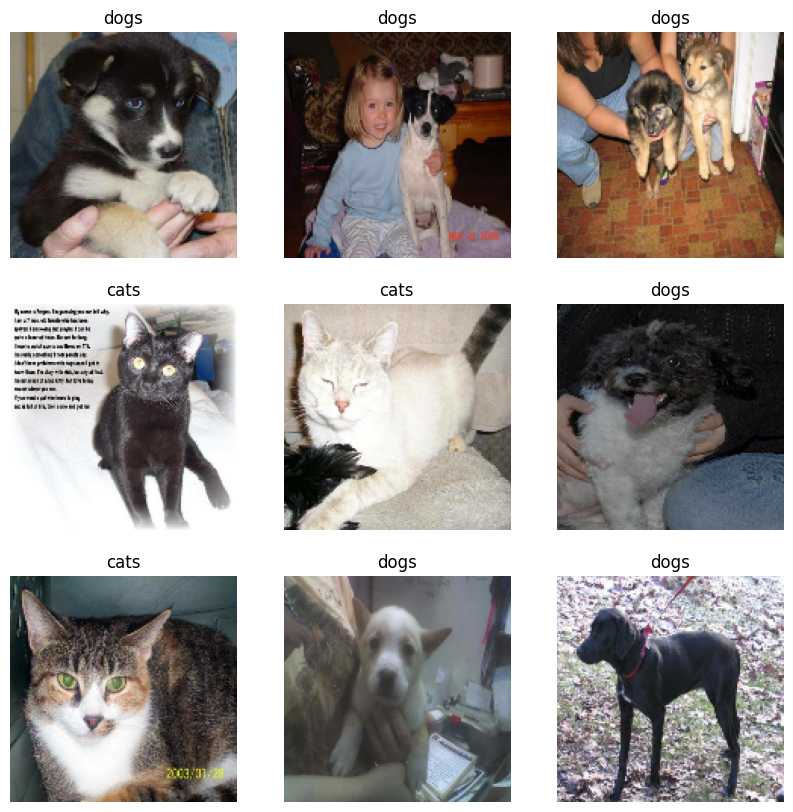

In [ ]:
#первые 9 изображений из обучающего набора вместе с их метками.
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [ ]:
data_augmentation = tf.keras.Sequential([
tf.keras.layers.RandomFlip("horizontal"), # симметрическое отражение
tf.keras.layers.RandomRotation(0.2), # поворот изображения
])

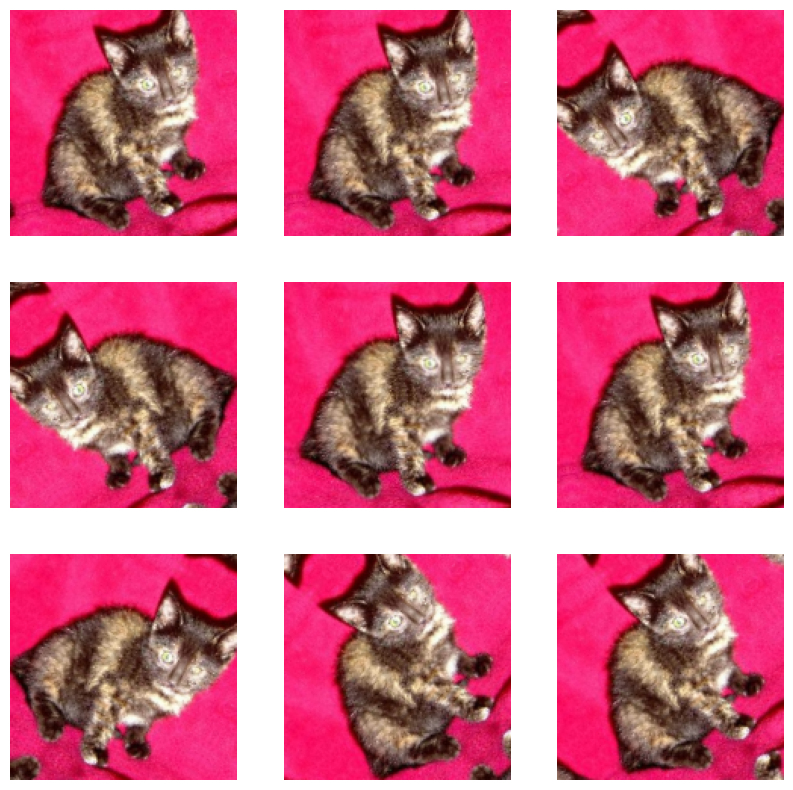

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis("off")

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
include_top=False,
weights="imagenet")

<ipython-input-9-92d49cf9cf9a>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
base_model.trainable = False
base_model.summary() # проверим что они заморозились

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 75, 75, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 75, 75, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 75, 75, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 75, 75, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 75, 75, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 75, 75, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 75, 75, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 75, 75, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 75, 75, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 75, 75, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 75, 75, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 77, 77, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 38, 38, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
inputs = tf.keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
metrics=["accuracy"])

In [ ]:
initial_epochs = 10
history = model.fit(train_dataset,
epochs=initial_epochs,
validation_data=validation_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.5347 - loss: 0.8715 - val_accuracy: 0.7314 - val_loss: 0.5316
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.6702 - loss: 0.6105 - val_accuracy: 0.8379 - val_loss: 0.3548
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.7663 - loss: 0.4747 - val_accuracy: 0.8973 - val_loss: 0.2675
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.8049 - loss: 0.3943 - val_accuracy: 0.9208 - val_loss: 0.2213
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8396 - loss: 0.3259 - val_accuracy: 0.9356 - val_loss: 0.1792
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8570 - loss: 0.2933 - val_accuracy: 0.9418 - val_loss: 0.1644
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.8582 - loss: 0.2873 - val_accuracy: 0.9369 - val_loss: 0.1516
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.8832 - loss: 0.2502 - val_accuracy: 0.9356 - 

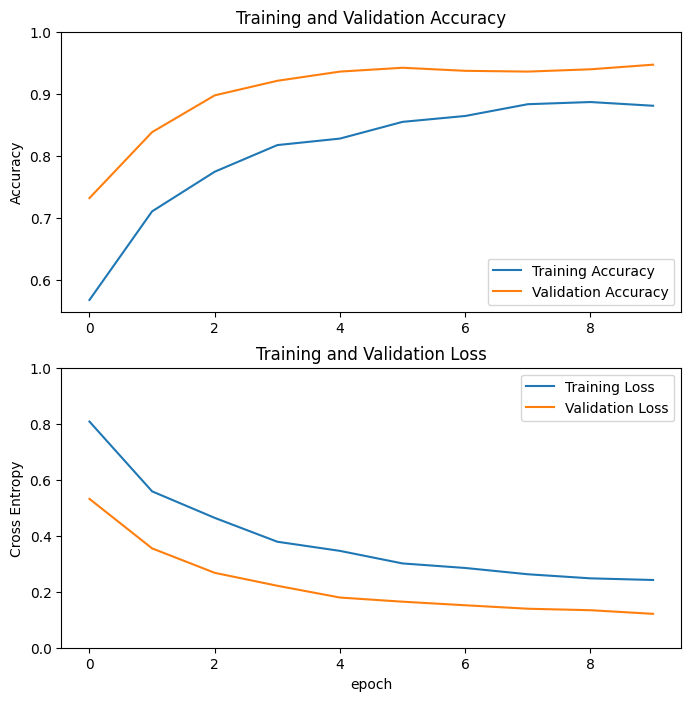

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()),1])
plt.title("Training and Validation Accuracy")
plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0,1.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()


In [ ]:
base_model.trainable = True

In [ ]:
new_rate = base_learning_rate/10
model.compile(
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
optimizer = tf.keras.optimizers.RMSprop(learning_rate=new_rate),
metrics=["accuracy"])
model.summary() # проверяем что слои разморозились


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 2,225,153 (8.49 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(train_dataset,
epochs=total_epochs,
initial_epoch=history.epoch[-1],
validation_data=validation_dataset)

Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 185ms/step - accuracy: 0.7879 - loss: 0.4721 - val_accuracy: 0.9653 - val_loss: 0.0971
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 172ms/step - accuracy: 0.8448 - loss: 0.3321 - val_accuracy: 0.9691 - val_loss: 0.0856
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.8808 - loss: 0.2780 - val_accuracy: 0.9703 - val_loss: 0.0854
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - accuracy: 0.8967 - loss: 0.2392 - val_accuracy: 0.9802 - val_loss: 0.0670
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.9049 - loss: 0.2081 - val_accuracy: 0.9814 - val_loss: 0.0545
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.9186 - loss: 0.1891 - val_accuracy: 0.9765 - val_loss: 0.0650
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.9216 - loss: 0.1919 - val_accuracy: 0.9802 - val_loss: 0.0576
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.9224 - loss: 0.1805 - 

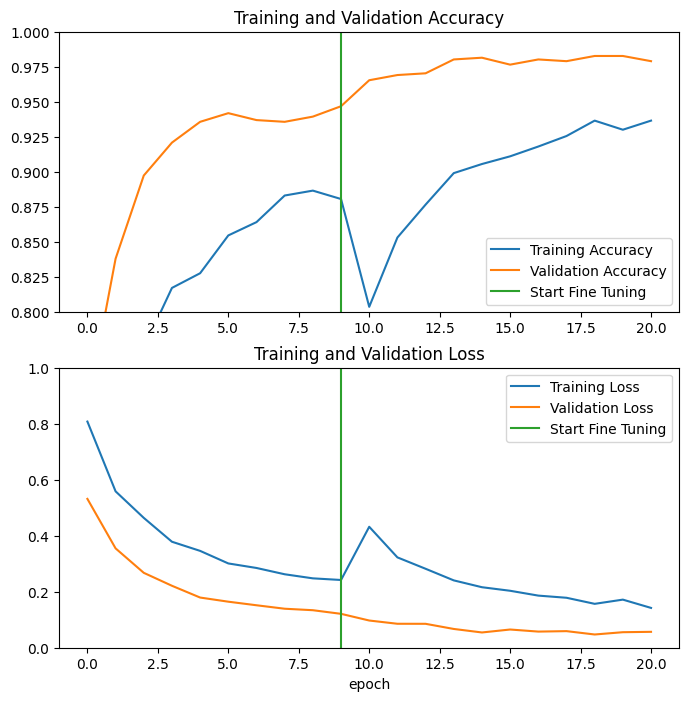

In [ ]:
acc += history_fine.history["accuracy"]
val_acc += history_fine.history["val_accuracy"]
loss += history_fine.history["loss"]
val_loss += history_fine.history["val_loss"]
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()


In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print("Test accuracy :", accuracy)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9818 - loss: 0.0807
Test accuracy : 0.984375


In [ ]:
model.save("our_first_convmodel.h5")

# Задание 1

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os

In [ ]:
_URL ="http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz"
path_to_zip = tf.keras.utils.get_file( "food-101",
origin=_URL,
extract=True)

4996278331/4996278331 ━━━━━━━━━━━━━━━━━━━━ 266s 0us/step


In [ ]:
!find / -type  d -name 'food-101'

find: ‘/proc/65/task/65/net’: Invalid argument
find: ‘/proc/65/net’: Invalid argument


In [ ]:
ls /root/.keras/datasets/food-101/food-101

images/  license_agreement.txt  meta/  README.txt  train/  validation/


In [ ]:
import shutil

PATH = os.path.join(os.path.dirname(path_to_zip), "food-101/food-101")

train_dir = os.path.join(PATH, "train")
validation_dir = os.path.join(PATH, "validation")

# Исходная папка с изображениями
images_dir = os.path.join(PATH, "images")

# Файлы с разделением train/test
train_txt = os.path.join(PATH, "meta", "train.txt")
test_txt = os.path.join(PATH, "meta", "test.txt")

In [ ]:
def create_dataset_folders(txt_file, target_dir):
    """Функция для перемещения изображений в train/ или validation/"""
    os.makedirs(target_dir, exist_ok=True)

    with open(txt_file, "r") as f:
        for line in f:
            image_path = os.path.join(images_dir, line.strip() + ".jpg")
            class_name = line.strip().split("/")[0]  # Название класса
            class_dir = os.path.join(target_dir, class_name)
            os.makedirs(class_dir, exist_ok=True)
            shutil.copy(image_path, class_dir)  # Копируем изображение


# Распределяем файлы в train и validation
create_dataset_folders(train_txt, train_dir)
create_dataset_folders(test_txt, validation_dir)

In [ ]:
# при загрузке функция вернет полный путь до корня распакованного архива
PATH = os.path.join(os.path.dirname(path_to_zip),
"food-101/food-101")
# директория train будет источником данных для обучения модели
train_dir = os.path.join(PATH, "train")
# директория validation будет источником данных для вылидации
validation_dir = os.path.join(PATH, "validation")
BATCH_SIZE = 32 # можете установить по желанию любой другой размер пакета
IMG_SIZE = (150, 150) # приведем к этому размеру все картинки
# сохраняем датасет для обучения модели
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
shuffle=True,
batch_size=BATCH_SIZE,
image_size=IMG_SIZE)
# аналогично получаем датасет для валидации
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
shuffle=True,
batch_size=BATCH_SIZE,
image_size=IMG_SIZE)

Found 75750 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


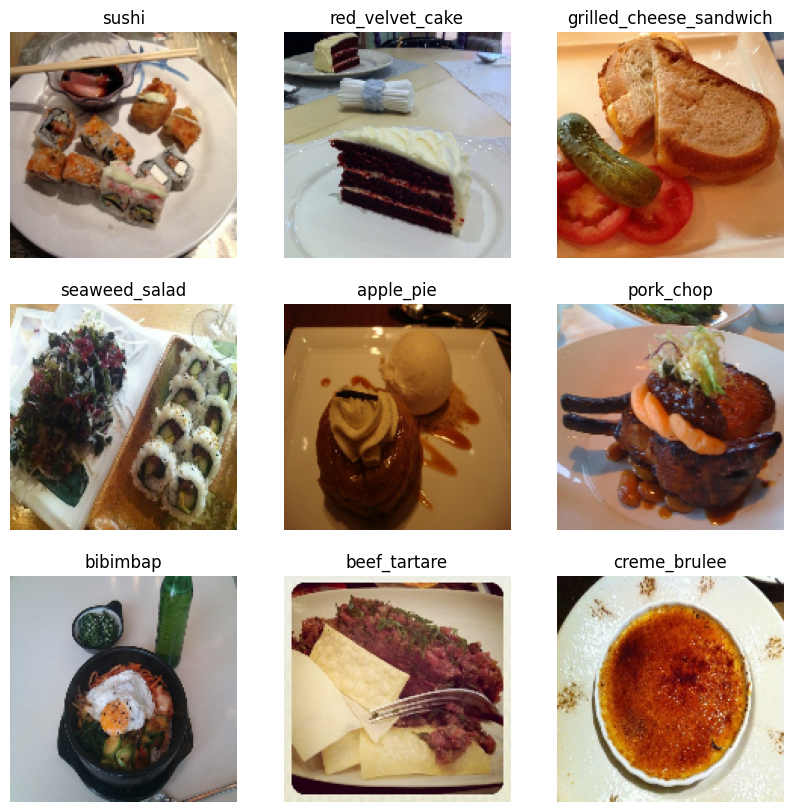

In [ ]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
tf.keras.layers.RandomFlip("horizontal"), # симметрическое отражение
tf.keras.layers.RandomRotation(0.2), # поворот изображения
])


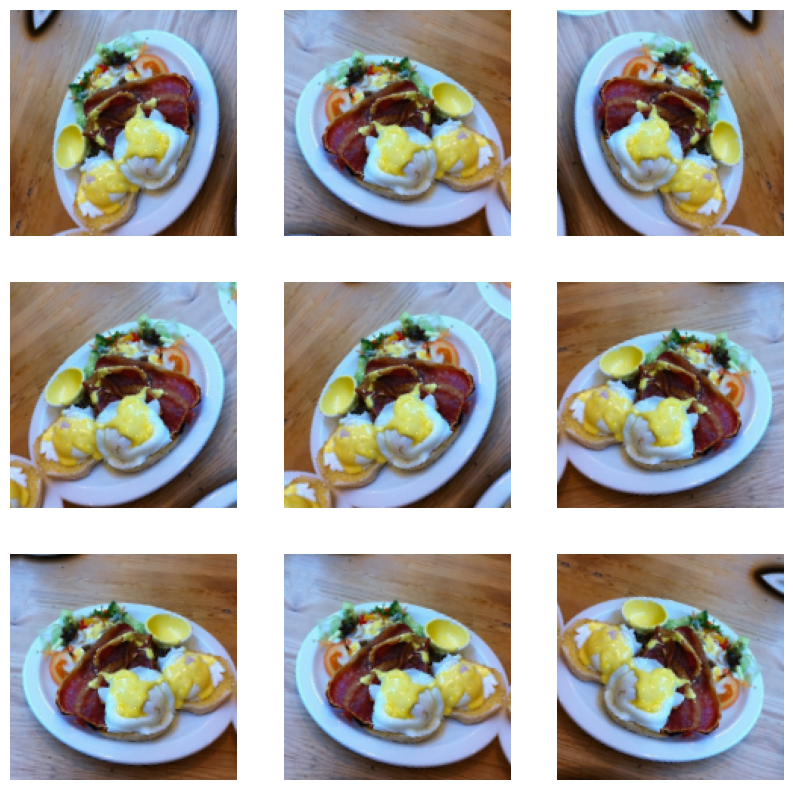

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis("off")


In [ ]:
!find / -type  d -name 'our_first_convmodel'

find: ‘/proc/65/task/65/net’: Invalid argument
find: ‘/proc/65/net’: Invalid argument
find: ‘/proc/13403’: No such file or directory


In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
include_top=False,
weights="imagenet")

<ipython-input-11-92d49cf9cf9a>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
base_model.trainable = False
base_model.summary() # проверим что они заморозились

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 75, 75, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 75, 75, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 75, 75, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 75, 75, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 75, 75, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 75, 75, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 75, 75, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 75, 75, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 75, 75, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 75, 75, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 75, 75, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 77, 77, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 38, 38, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
inputs = tf.keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
metrics=["accuracy"])


In [ ]:
initial_epochs = 10
history = model.fit(train_dataset,
epochs=initial_epochs,
validation_data=validation_dataset)

Epoch 1/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 209s 85ms/step - accuracy: 0.0103 - loss: -2151.7644 - val_accuracy: 0.0107 - val_loss: -8115.8862
Epoch 2/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 194s 82ms/step - accuracy: 0.0104 - loss: -10809.2607 - val_accuracy: 0.0107 - val_loss: -16244.8779
Epoch 3/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 202s 82ms/step - accuracy: 0.0104 - loss: -19462.8730 - val_accuracy: 0.0107 - val_loss: -24387.8379
Epoch 4/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 238s 97ms/step - accuracy: 0.0105 - loss: -28101.3906 - val_accuracy: 0.0106 - val_loss: -32507.1758
Epoch 5/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 198s 70ms/step - accuracy: 0.0105 - loss: -36770.4531 - val_accuracy: 0.0107 - val_loss: -40611.8906
Epoch 6/10
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.0104 - loss: -45401.3320

KeyboardInterrupt: 

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()),1])
plt.title("Training and Validation Accuracy")
plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0,1.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

# Задание 1(другой датасет)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os

In [ ]:
_URL ="https://storage.googleapis.com/learning-datasets/horse-or-human.zip"
path_to_zip_train = tf.keras.utils.get_file( "horse-or-human-train",
origin=_URL,
extract=True)

In [ ]:
_URL ="https://storage.googleapis.com/learning-datasets/validation-horse-or-human.zip"
path_to_zip_valid = tf.keras.utils.get_file( "horse-or-human-valid",
origin=_URL,
extract=True)

In [ ]:
ls /root/.keras/datasets

horse-or-human-train/         horse-or-human-valid/
horse-or-human-train_archive  horse-or-human-valid_archive


In [ ]:
BATCH_SIZE = 32 # можете установить по желанию любой другой размер пакета
IMG_SIZE = (150, 150) # приведем к этому размеру все картинки
# сохраняем датасет для обучения модели
train_dataset = tf.keras.utils.image_dataset_from_directory(path_to_zip_train,
shuffle=True,
batch_size=BATCH_SIZE,
image_size=IMG_SIZE)
# аналогично получаем датасет для валидации
validation_dataset = tf.keras.utils.image_dataset_from_directory(path_to_zip_valid,
shuffle=True,
batch_size=BATCH_SIZE,
image_size=IMG_SIZE)

Found 1027 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


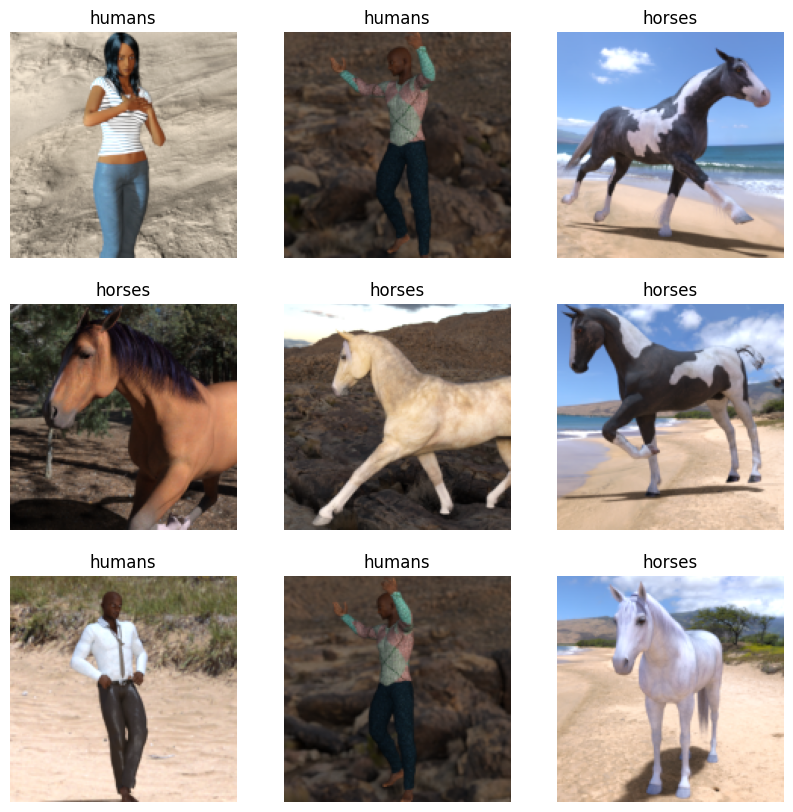

In [ ]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
tf.keras.layers.RandomFlip("horizontal"), # симметрическое отражение
tf.keras.layers.RandomRotation(0.2), # поворот изображения
])

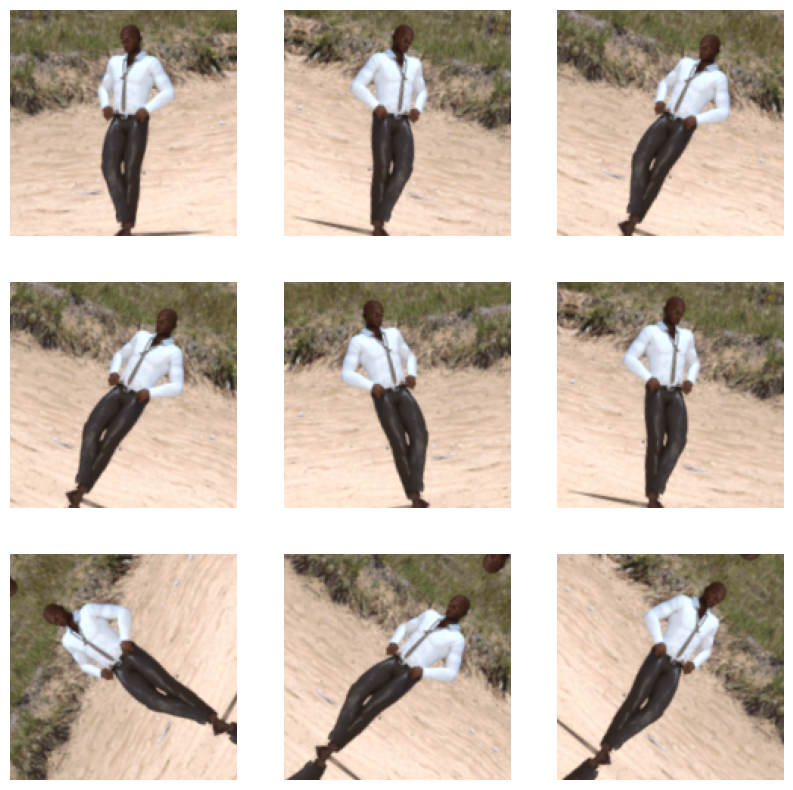

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis("off")

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
include_top=False,
weights="imagenet")

<ipython-input-17-92d49cf9cf9a>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
base_model.trainable = False
base_model.summary() # проверим что они заморозились

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 75, 75, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 75, 75, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 75, 75, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 75, 75, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 75, 75, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 75, 75, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 75, 75, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 75, 75, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 75, 75, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 75, 75, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 75, 75, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 77, 77, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 38, 38, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
inputs = tf.keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
metrics=["accuracy"])

In [ ]:
initial_epochs = 10
history = model.fit(train_dataset,
epochs=initial_epochs,
validation_data=validation_dataset)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 217ms/step - accuracy: 0.4925 - loss: 1.5606 - val_accuracy: 0.5045 - val_loss: 1.0634
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.5269 - loss: 0.8628 - val_accuracy: 0.5045 - val_loss: 0.7596
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.5731 - loss: 0.7451 - val_accuracy: 0.5179 - val_loss: 0.6390
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.6654 - loss: 0.5971 - val_accuracy: 0.5446 - val_loss: 0.5386
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.7133 - loss: 0.5166 - val_accuracy: 0.6205 - val_loss: 0.4141
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.8224 - loss: 0.3882 - val_accuracy: 0.6830 - val_loss: 0.3575
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.8328 - loss: 0.3718 - val_accuracy: 0.7009 - val_loss: 0.3337
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step - accuracy: 0.8521 - loss: 0.3234 - val_accuracy: 0

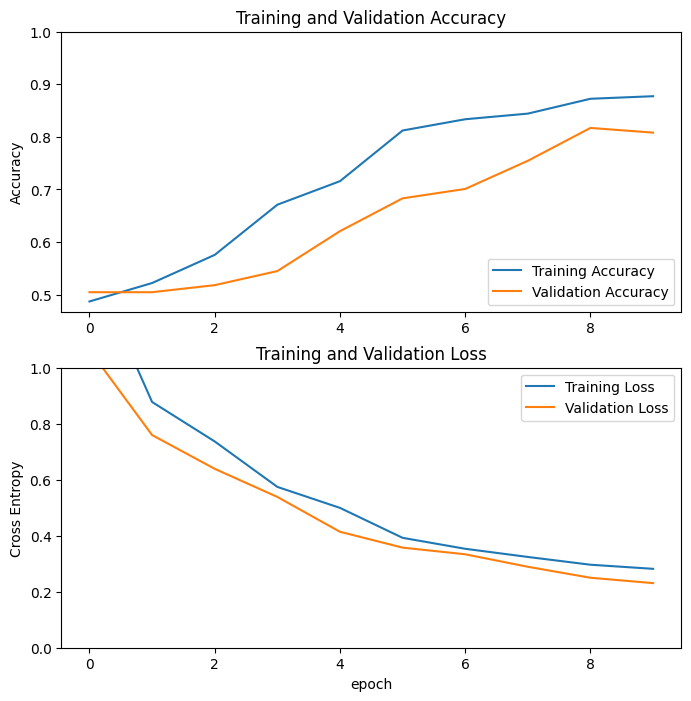

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()),1])
plt.title("Training and Validation Accuracy")
plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0,1.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
new_rate = base_learning_rate/10
model.compile(
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
optimizer = tf.keras.optimizers.RMSprop(learning_rate=new_rate),
metrics=["accuracy"])
model.summary() # проверяем что слои разморозились

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 2,225,153 (8.49 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(train_dataset,
epochs=total_epochs,
initial_epoch=history.epoch[-1],
validation_data=validation_dataset)

Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 257ms/step - accuracy: 0.8607 - loss: 0.3299 - val_accuracy: 0.9911 - val_loss: 0.0979
Epoch 11/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 168ms/step - accuracy: 0.9424 - loss: 0.2000 - val_accuracy: 1.0000 - val_loss: 0.0605
Epoch 12/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.9630 - loss: 0.1320 - val_accuracy: 1.0000 - val_loss: 0.0489
Epoch 13/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.9886 - loss: 0.0772 - val_accuracy: 1.0000 - val_loss: 0.0313
Epoch 14/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.9804 - loss: 0.0754 - val_accuracy: 1.0000 - val_loss: 0.0262
Epoch 15/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 221ms/step - accuracy: 0.9888 - loss: 0.0473 - val_accuracy: 1.0000 - val_loss: 0.0245
Epoch 16/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.9968 - loss: 0.0365 - val_accuracy: 1.0000 - val_loss: 0.0182
Epoch 17/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.9956 - loss: 0.0298 - val_

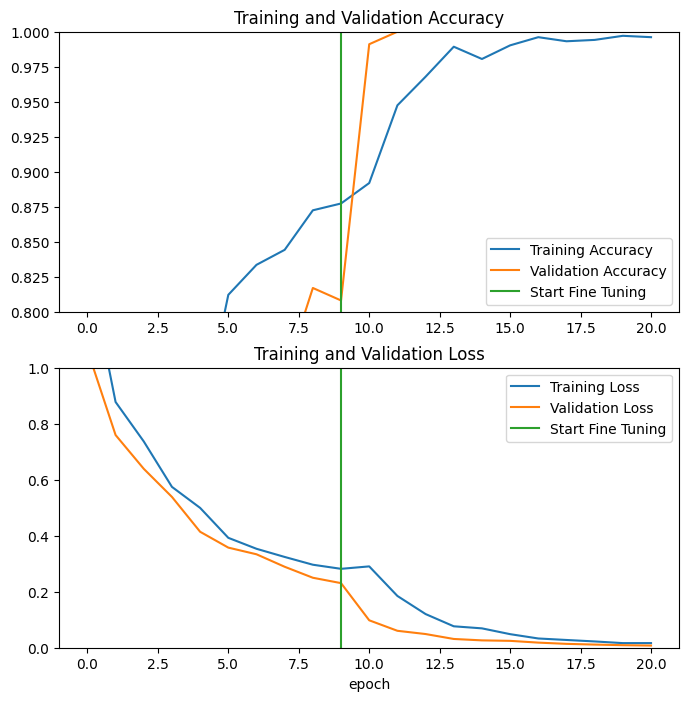

In [ ]:
acc += history_fine.history["accuracy"]
val_acc += history_fine.history["val_accuracy"]
loss += history_fine.history["loss"]
val_loss += history_fine.history["val_loss"]
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 0.0054


In [ ]:
path_to_zip_test = tf.keras.utils.get_file("horse",
origin=URL,
extract=True)

In [ ]:
import requests
from PIL import Image
from io import BytesIO
def preprocess_image_from_url(url):
    # Загружаем изображение из интернета
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    # Преобразуем в RGB (если, например, PNG с альфа-каналом)
    img = img.convert("RGB")

    # Изменяем размер под модель
    img = img.resize((150, 150))

    # Преобразуем в массив
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Добавляем размерность батча
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)  # Предобработка
    return img_array

In [ ]:
# URL изображения
image_url = "https://t3.ftcdn.net/jpg/00/11/02/28/240_F_11022865_au50XJQ2xLuoNTIy0qGSNxbLsaIDrFrI.jpg"

# Загружаем и обрабатываем изображение
img_array = preprocess_image_from_url(image_url)

# Предсказываем класс
prediction = model.predict(img_array)

# Преобразуем логиты в вероятность (для бинарной классификации)
probability = tf.nn.sigmoid(prediction).numpy()

print(f"Prediction: {probability[0][0]:.4f}")
#horse prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Prediction: 0.3381


In [ ]:
# URL изображения
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/Human.svg/800px-Human.svg.png"

# Загружаем и обрабатываем изображение
img_array = preprocess_image_from_url(image_url)

# Предсказываем класс
prediction = model.predict(img_array)

# Преобразуем логиты в вероятность (для бинарной классификации)
probability = tf.nn.sigmoid(prediction).numpy()

print(f"Prediction: {probability[0][0]:.4f}")
#human

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction: 0.3325


# 2.

In [ ]:
from __future__ import absolute_import
from __future__ import division
import keras
from keras.datasets import mnist
import numpy as np


In [ ]:
# Считываем данные из MNIST
(x_train, _), (x_test, _) = mnist.load_data()
# Нормируем данные и приводим массивы к виду (N,size1,size1,1)
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise
# Ограничим итоговые значения интервалом [0,1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [ ]:
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
latent_dim = 16
# Зададим два сверточных слоя и число нейронов в каждом слое:
layer_filters = [32, 64]


In [ ]:
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model



In [ ]:
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
encoder_inputs = Input(shape=input_shape, name='encoder_input')
x = encoder_inputs
# Стек из сверточных слоев (strides - дискрет сдвига окна свертки
# в пикселях, padding - без заполнения нулями):
for filters in layer_filters:
  x = Conv2D(filters=filters,
  kernel_size=kernel_size,
  strides=2,
  activation='relu',
  padding='same')(x)
# Запоминаем размерность выхода для построения модели декодера
shape = x.shape
# Преобразуем многомерный массив в вектор
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vecto')(x)
# Итоговый код - одномерный вектор меньшей размерности (latent_dim)
# Итоговая модель энкодера:
encoder = Model(encoder_inputs , latent, name='encoder')


In [ ]:
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 14, 14, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_vecto (Dense)                 │ (None, 16)                  │          50,192 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,008 (269.56 KB)

 Trainable params: 69,008 (269.56 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# Обратное преобразование к размеру "shape":
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# Выход должен быть трехмерным массивом:
x = Reshape((shape[1], shape[2], shape[3]))(x)
# Вместо сверточных слоев "разверточные", цикл в обратном порядке:
for filters in layer_filters[::-1]:
  x = Conv2DTranspose(filters=filters,
  kernel_size=kernel_size,
  strides=2,
  activation='relu',
  padding='same')(x)
x = Conv2DTranspose(filters=1,
kernel_size=kernel_size,
padding='same')(x)
outputs = Activation('sigmoid', name='decoder_output')(x)

In [ ]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3136)                │          53,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_5 (Reshape)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_18                  │ (None, 14, 14, 64)          │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_19                  │ (None, 28, 28, 32)          │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_20                  │ (None, 28, 28, 1)           │             289 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Activation)          │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 108,993 (425.75 KB)

 Trainable params: 108,993 (425.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder = Model(encoder_inputs,
decoder(encoder(encoder_inputs)),
name='autoencoder')
autoencoder.compile(loss='mse', optimizer='adam')

In [ ]:
history = autoencoder.fit(x_train_noisy,
x_train,
validation_data=(x_test_noisy, x_test),
epochs=30,
batch_size=batch_size)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0853 - val_loss: 0.0338
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0298 - val_loss: 0.0236
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0231 - val_loss: 0.0209
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0206 - val_loss: 0.0192
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0189 - val_loss: 0.0181
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0180 - val_loss: 0.0175
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0174 - val_loss: 0.0172
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0169 - val_loss: 0.0170
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0165 - val_loss: 0.0167
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0162 - val_loss: 0.0164
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0160 - val_loss: 0.0163
Epoch 12/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/ste

# Задание 2

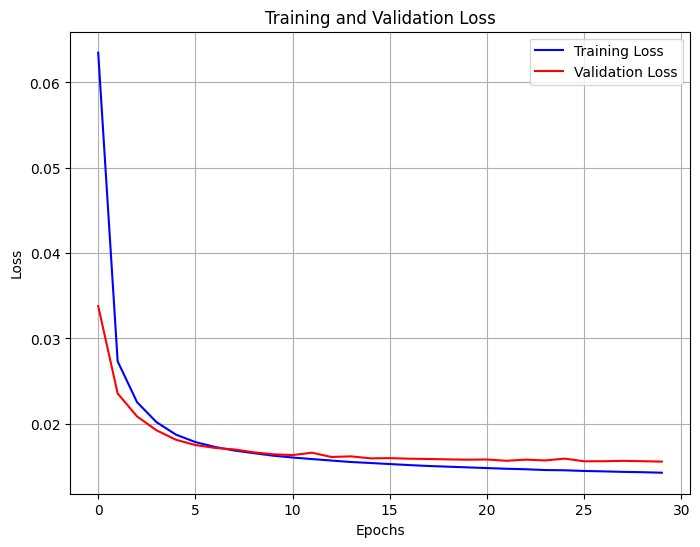

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Создаём график
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(loss)), loss, label="Training Loss", color='blue')
plt.plot(np.arange(len(val_loss)), val_loss, label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


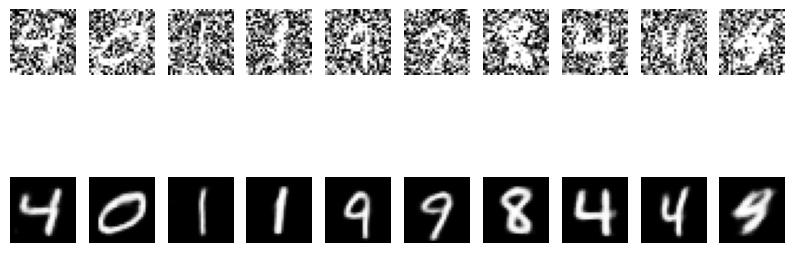

In [ ]:
n = 10
indices = np.random.randint(0, x_test.shape[0], n)
test_images = x_test_noisy[indices]
decoded_images = autoencoder.predict(test_images)

# Отображаем
plt.figure(figsize=(10, 4))
for i in range(n):
    # Оригинал (зашумленный)
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].reshape(image_size, image_size), cmap='gray')
    plt.axis('off')

    # Восстановленное изображение
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images[i].reshape(image_size, image_size), cmap='gray')
    plt.axis('off')

plt.show()

In [ ]:
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
latent_dim = 16
# Зададим три сверточных слоя и число нейронов в каждом слое:
layer_filters = [32, 64, 128]

In [ ]:
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
encoder_inputs = Input(shape=input_shape, name='encoder_input')
x = encoder_inputs
# Стек из сверточных слоев (strides - дискрет сдвига окна свертки
# в пикселях, padding - без заполнения нулями):
for filters in layer_filters:
  x = Conv2D(filters=filters,
  kernel_size=kernel_size,
  strides=2,
  activation='relu',
  padding='same')(x)
# Запоминаем размерность выхода для построения модели декодера
shape = x.shape
# Преобразуем многомерный массив в вектор
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vecto')(x)
# Итоговый код - одномерный вектор меньшей размерности (latent_dim)
# Итоговая модель энкодера:
encoder = Model(encoder_inputs , latent, name='encoder')


In [ ]:
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 14, 14, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_vecto (Dense)                 │ (None, 16)                  │          32,784 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 125,456 (490.06 KB)

 Trainable params: 125,456 (490.06 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# Обратное преобразование к размеру "shape":
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# Выход должен быть трехмерным массивом:
x = Reshape((shape[1], shape[2], shape[3]))(x)
# Вместо сверточных слоев "разверточные", цикл в обратном порядке:
for filters in layer_filters[::-1]:
  x = Conv2DTranspose(filters=filters,
  kernel_size=kernel_size,
  strides=2,
  activation='relu',
  padding='same')(x)
x = Conv2DTranspose(filters=1,
kernel_size=kernel_size,
padding='same')(x)
from keras.layers import Cropping2D
x = Cropping2D(((2, 2), (2, 2)))(x)
outputs = Activation('sigmoid', name='decoder_output')(x)

In [ ]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 2048)                │          34,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_6 (Reshape)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_21                  │ (None, 8, 8, 128)           │         147,584 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_22                  │ (None, 16, 16, 64)          │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_23                  │ (None, 32, 32, 32)          │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_24                  │ (None, 32, 32, 1)           │             289 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping2d_1 (Cropping2D)            │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Activation)          │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 274,945 (1.05 MB)

 Trainable params: 274,945 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder = Model(encoder_inputs,
decoder(encoder(encoder_inputs)),
name='autoencoder')
autoencoder.compile(loss='mse', optimizer='adam')

In [ ]:
history_2 = autoencoder.fit(x_train_noisy,
x_train,
validation_data=(x_test_noisy, x_test),
epochs=30,
batch_size=batch_size)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.0814 - val_loss: 0.0260
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.0238 - val_loss: 0.0191
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0189 - val_loss: 0.0174
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0173 - val_loss: 0.0165
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0164 - val_loss: 0.0159
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0156 - val_loss: 0.0156
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0152 - val_loss: 0.0152
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0148 - val_loss: 0.0152
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0145 - val_loss: 0.0151
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0143 - val_loss: 0.0148
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0140 - val_loss: 0.0148
Epoch 12/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 

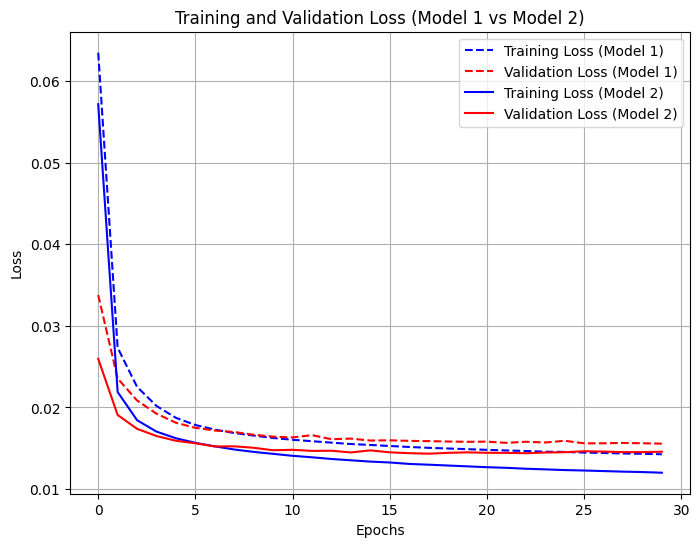

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Получаем значения loss и val_loss из истории обучения
loss_1 = history.history["loss"]
val_loss_1 = history.history["val_loss"]

loss_2 = history_2.history["loss"]
val_loss_2 = history_2.history["val_loss"]

# Создаём график
plt.figure(figsize=(8, 6))

# График для первой модели (history)
plt.plot(np.arange(len(loss_1)), loss_1, label="Training Loss (Model 1)", linestyle='dashed', color='blue')
plt.plot(np.arange(len(val_loss_1)), val_loss_1, label="Validation Loss (Model 1)", linestyle='dashed', color='red')

# График для второй модели (history_2)
plt.plot(np.arange(len(loss_2)), loss_2, label="Training Loss (Model 2)", color='blue')
plt.plot(np.arange(len(val_loss_2)), val_loss_2, label="Validation Loss (Model 2)", color='red')

# Оформление графика
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (Model 1 vs Model 2)")
plt.legend()
plt.grid(True)
plt.show()
